In [1]:
%matplotlib inline
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss, accuracy_score, precision_recall_fscore_support, confusion_matrix

### 1. データ読み込み

In [2]:
df = pd.read_csv("../ks-projects-201801.csv")

In [3]:
# 訓練データとテストデータを分ける
df = df[df["state"] != "live"]
df["state"] = df["state"]=="successful"
X = df[:].values
y = df["state"].values
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

### 2. 学習データ生成用の関数定義

In [4]:
# ログ出力関数
def PrintLog(log):
    #print(log)
    return

#### 訓練データ、テストデータをDataFrameに変換して返す関数

In [5]:
def ConvertDataFrame(p_x_data):
    PrintLog("enter : %s"%sys._getframe().f_code.co_name)
    
    df_x_data = pd.DataFrame({"ID":p_x_data[:, 0],
                            "name":p_x_data[:, 1],
                            "category":p_x_data[:, 2],
                            "main_category":p_x_data[:, 3],
                            "currency":p_x_data[:, 4],
                            "deadline":p_x_data[:, 5],
                            "goal":p_x_data[:, 6],
                            "launched":p_x_data[:, 7],
                            "pledged":p_x_data[:, 8],
                            "state":p_x_data[:, 9],
                            "backers":p_x_data[:, 10],
                            "country":p_x_data[:, 11],
                            "usd pledged":p_x_data[:, 12],
                            "usd_pledged_real":p_x_data[:, 13],
                            "usd_goal_real":p_x_data[:, 14]},
                            columns=["ID", "name", "category", "main_category", "currency", "deadline",
                                     "goal", "launched", "pledged", "state", "backers", "country", "usd pledged",
                                     "usd_pledged_real", "usd_goal_real"])
    
    PrintLog("leave : %s"%sys._getframe().f_code.co_name)
    return df_x_data

#### データ欠損レコード、外れ値を含むレコードを削除

In [6]:
def RemoveRecord(p_x_train, p_y_train):
    PrintLog("enter : %s"%sys._getframe().f_code.co_name)
    print("削除前:%d"%len(p_x_train))
    
    df_x_train = ConvertDataFrame(p_x_train)
    
    # 欠損値を含むレコード削除
    index = df_x_train.isnull().any(axis=1)
    df_x_train = df_x_train[~index]
    df_x_train.index = np.arange(0, len(df_x_train))
    
    # 「usd_goal_real」の外れ値となるレコードを削除
    df_x_train["usd_goal_real_log"] = np.log10(df_x_train["usd_goal_real"].values.astype(np.float64) + 1)
    
    # 上側境界値
    thrHigh = df_x_train["usd_goal_real_log"].describe().loc["75%"] + 1.5 * (df_x_train["usd_goal_real_log"].describe().loc["75%"] - df_x_train["usd_goal_real_log"].describe().loc["25%"])
    # 下側境界値
    thrLow = df_x_train["usd_goal_real_log"].describe().loc["25%"] - 1.5 * (df_x_train["usd_goal_real_log"].describe().loc["75%"] - df_x_train["usd_goal_real_log"].describe().loc["25%"])
    
    # データ有効範囲内のレコード
    index_goal = (thrLow < df_x_train["usd_goal_real_log"]) & (df_x_train["usd_goal_real_log"] < thrHigh)
    
    # 平均支援額(=usd_pledged_real / backers)を計算して、外れ値となるレコードを削除
    df_x_train["average_back"] = df_x_train["usd_pledged_real"].values / np.maximum(df_x_train["backers"].values, np.ones(len(df_x_train)))
    df_x_train["average_back"] = df_x_train["average_back"].astype(float)
    
    df = df_x_train[df_x_train["state"] == True]
    # 上側境界値
    thrHigh = df["average_back"].describe().loc["75%"] + 1.5 * (df["average_back"].describe().loc["75%"] - df["average_back"].describe().loc["25%"])
    # 下側境界値
    thrLow = df["average_back"].describe().loc["25%"] - 1.5 * (df["average_back"].describe().loc["75%"] - df["average_back"].describe().loc["25%"])
    
    # データ有効範囲内のレコード
    index_average_back = (thrLow < df_x_train["average_back"]) & (df_x_train["average_back"] < thrHigh)
    
    # すべての条件を満たすインデックスのみ抽出
    index = index_goal & index_average_back
    df_x_train = df_x_train[index]
    
    # 失敗したデータを成功したデータ件数程度に絞る
    df_success = df_x_train[df_x_train["state"] == True]
    df_Failed = df_x_train[df_x_train["state"] != True]
    # 失敗したデータを絞る
    df_Failed = df_Failed.sample(int(len(df_Failed) * 0.7))
    print("成功件数=%d, 失敗件数=%d"%(len(df_success), len(df_Failed)))
    # 返却用に結合
    df_x_train = pd.concat([df_success, df_Failed], axis = 0)

    # 関数内で追加したカラム削除
    df_x_train = df_x_train.drop(["usd_goal_real_log", "average_back"], axis = 1)
    
    # 返却用データ
    p_x_train = df_x_train[:].values
    p_y_train = df_x_train["state"].values.astype(int)
    
    print("削除後:%d"%len(p_x_train))
    PrintLog("leave : %s"%sys._getframe().f_code.co_name)
    
    return p_x_train, p_y_train

#### 特徴量を追加したDataFrameを返す関数

In [7]:
def AddFeature(p_df_x_data):
    PrintLog("enter : %s"%sys._getframe().f_code.co_name)
    
    # 成功率が高い国か、そうでないかのカラムを追加(33%をしきい値とする)
    country_index = (p_df_x_data["country"] == "US") | \
                    (p_df_x_data["country"] == "GB") | \
                    (p_df_x_data["country"] == "CA") | \
                    (p_df_x_data["country"] == "FR") | \
                    (p_df_x_data["country"] == "SE") | \
                    (p_df_x_data["country"] == "NZ") | \
                    (p_df_x_data["country"] == "DK") | \
                    (p_df_x_data["country"] == "HK") | \
                    (p_df_x_data["country"] == "SG") | \
                    (p_df_x_data["country"] == "LU")
    p_df_x_data.loc[country_index, "country_success_rate_class"] = "high"
    p_df_x_data.loc[~country_index, "country_success_rate_class"] = "low"
        
    # カテゴリ別で成功率が低位の層、中間の層、上位の層を分けるカラムを追加する
    # 低位層：成功率40%未満、中間層：40%以上 60%未満、上位層：60%以上
    cate_high_index = (p_df_x_data["main_category"] == "Dance") | \
                    (p_df_x_data["main_category"] == "Theater") | \
                    (p_df_x_data["main_category"] == "Comics")
    cate_low_index = (p_df_x_data["main_category"] == "Publishing") | \
                    (p_df_x_data["main_category"] == "Photography") | \
                    (p_df_x_data["main_category"] == "Fasion") | \
                    (p_df_x_data["main_category"] == "Food") | \
                    (p_df_x_data["main_category"] == "Crafts") | \
                    (p_df_x_data["main_category"] == "journalism") | \
                    (p_df_x_data["main_category"] == "Technology")
    # 上位層
    p_df_x_data.loc[cate_high_index, "main_category_success_rate_class"] = "high"
    # 中位層
    p_df_x_data.loc[~(cate_high_index | cate_low_index), "main_category_success_rate_class"] = "mid"
    # 下位層
    p_df_x_data.loc[cate_low_index, "main_category_success_rate_class"] = "low"
    
    # クラウドファンディング期間
    launched_time = pd.to_datetime(p_df_x_data["launched"], format = "%Y-%m-%d %H:%M:%S")
    deadline_time = pd.to_datetime(p_df_x_data["deadline"], format = "%Y-%m-%d %H:%M:%S")
    p_df_x_data["term_days"] = (deadline_time - launched_time).dt.days
    
    # クラウドファンディング立ち上げ月
    p_df_x_data["launched_month"] = np.array(pd.to_datetime(p_df_x_data["launched"]).dt.month)
    # クラウドファンディング締め切り月
    p_df_x_data["deadline_month"] = np.array(pd.to_datetime(p_df_x_data["deadline"]).dt.month)
    
    # 「name」列のポジティブワードが含まれているか
    positive_word_index = ((p_df_x_data["name"].str.contains("New", na = False)) |
                            (p_df_x_data["name"].str.contains("new", na = False)) |
                            (p_df_x_data["name"].str.contains("Debut", na = False)) |
                            (p_df_x_data["name"].str.contains("First", na = False)))
    p_df_x_data.loc[positive_word_index, "positive_word"] = True
    p_df_x_data.loc[~positive_word_index, "positive_word"] = False
    
    PrintLog("leave : %s"%sys._getframe().f_code.co_name)
    return p_df_x_data

#### 前処理

In [8]:
def PreProcess(p_df_x_train, p_df_x_test):
    PrintLog("enter : %s"%sys._getframe().f_code.co_name)
    
    # 木モデルは標準化不要、One-hot表現不要ということなので、カテゴリ変数はLabelEncodeして
    # 標準化だけ実行する
    
    # 「usd_goal_real」は対数変換してレンジを狭くしてみる
    p_df_x_train["usd_goal_real"] = np.log10(p_df_x_train["usd_goal_real"].values.astype(np.float64) + 1)
    p_df_x_test["usd_goal_real"] = np.log10(p_df_x_test["usd_goal_real"].values.astype(np.float64) + 1)
    
    # データ標準化
    stdsc = StandardScaler()
    for col in ["usd_goal_real", "term_days"]:
        p_df_x_train[col] = stdsc.fit_transform(p_df_x_train[col].values.reshape(-1, 1)).reshape(-1)
        p_df_x_test[col] = stdsc.transform(p_df_x_test[col].values.reshape(-1, 1)).reshape(-1)
    
    # LabelEncode
    le = LabelEncoder()
    for col in ["category", "main_category", "currency", "country"]:
        le.fit(df[col])
        p_df_x_train[col] = le.transform(p_df_x_train[col])
        p_df_x_test[col] = le.transform(p_df_x_test[col])
    for col in ["country_success_rate_class", "main_category_success_rate_class", "positive_word"]:
        le.fit(p_df_x_train[col])
        p_df_x_train[col] = le.transform(p_df_x_train[col])
        p_df_x_test[col] = le.transform(p_df_x_test[col])
    
    PrintLog("leave : %s"%sys._getframe().f_code.co_name)
    return p_df_x_train, p_df_x_test

#### 学習用データの作成

In [9]:
def GetLearningData(p_x_train, p_x_test):
    PrintLog("enter : %s"%sys._getframe().f_code.co_name)
    
    # DataFrameに変換
    df_x_train = ConvertDataFrame(p_x_train)
    df_x_test = ConvertDataFrame(p_x_test)
    
    print("元データ")
    display(df_x_train.head())
    
    # 特徴量追加
    df_x_train = AddFeature(df_x_train)
    df_x_test = AddFeature(df_x_test)
    
    print("特徴量追加後")
    display(df_x_train.head())

    # 前処理(データ標準化、One-hotベクトル化)
    df_x_train, df_x_test = PreProcess(df_x_train, df_x_test)
    
    print("前処理後")
    display(df_x_train.head())
    
    # 不要なカラムを削除
    for col in ["ID", "name", "deadline", "goal", "launched", "pledged", "state", "backers", "usd pledged", "usd_pledged_real"]:
        df_x_train = df_x_train.drop(col, axis = 1)
        df_x_test = df_x_test.drop(col, axis = 1)
        
    # ラッパー法で特徴量選択した結果削除した方がよいカラム削除
    remove_column = []

    for col in remove_column:
        df_x_train = df_x_train.drop(col, axis = 1)
        df_x_test = df_x_test.drop(col, axis = 1)
    
    PrintLog("leave : %s"%sys._getframe().f_code.co_name)
        
    return df_x_train, df_x_test

### 3. 学習データ作成

In [10]:
# 欠損レコード、外れ値を含むレコード削除
X_train, y_train = RemoveRecord(X_train, y_train)

# 学習データ生成クラスでデータ作成
df_X_train, df_X_test = GetLearningData(X_train, X_test)

# 訓練データ、テストデータをセット
X_train = df_X_train[:].values
X_test = df_X_test[:].values

print("トレーニングデータ")
display(df_X_train.head())
display(df_X_train.tail())
print("テストデータ")
display(df_X_test.head())
display(df_X_test.tail())

削除前:300689
成功件数=97394, 失敗件数=125117
削除後:222511
元データ


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,85280990,"Spectral Cinema: the ""Spirit Saints"" series by...",Photography,Photography,USD,2014-03-25,1700,2014-02-20 06:41:03,2280,True,44,US,2280,2280,1700
1,132377102,[ The Soulless Machine ] - an MFA thesis exh...,Conceptual Art,Art,USD,2012-03-30,1600,2012-03-05 20:21:13,1665,True,15,US,1665,1665,1600
2,455532205,And Everyone Was There,Experimental,Film & Video,CAD,2016-10-09,3000,2016-09-13 23:27:23,3208,True,55,CA,348.23,2436.58,2278.6
3,1585925137,"Race for the Iron Throne E-Book, Take 2",Publishing,Publishing,USD,2015-11-17,9500,2015-11-03 23:20:47,10785,True,189,US,10785,10785,9500
4,731021947,SALVAGERS: The Wreck Raiders (Complete Trade P...,Graphic Novels,Comics,USD,2017-10-04,6500,2017-09-04 14:23:55,12879,True,463,US,4121,12879,6500


特徴量追加後


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,country,usd pledged,usd_pledged_real,usd_goal_real,country_success_rate_class,main_category_success_rate_class,term_days,launched_month,deadline_month,positive_word
0,85280990,"Spectral Cinema: the ""Spirit Saints"" series by...",Photography,Photography,USD,2014-03-25,1700,2014-02-20 06:41:03,2280,True,...,US,2280,2280,1700,high,low,32,2,3,False
1,132377102,[ The Soulless Machine ] - an MFA thesis exh...,Conceptual Art,Art,USD,2012-03-30,1600,2012-03-05 20:21:13,1665,True,...,US,1665,1665,1600,high,mid,24,3,3,False
2,455532205,And Everyone Was There,Experimental,Film & Video,CAD,2016-10-09,3000,2016-09-13 23:27:23,3208,True,...,CA,348.23,2436.58,2278.6,high,mid,25,9,10,False
3,1585925137,"Race for the Iron Throne E-Book, Take 2",Publishing,Publishing,USD,2015-11-17,9500,2015-11-03 23:20:47,10785,True,...,US,10785,10785,9500,high,low,13,11,11,False
4,731021947,SALVAGERS: The Wreck Raiders (Complete Trade P...,Graphic Novels,Comics,USD,2017-10-04,6500,2017-09-04 14:23:55,12879,True,...,US,4121,12879,6500,high,high,29,9,10,False


前処理後


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,country,usd pledged,usd_pledged_real,usd_goal_real,country_success_rate_class,main_category_success_rate_class,term_days,launched_month,deadline_month,positive_word
0,85280990,"Spectral Cinema: the ""Spirit Saints"" series by...",104,11,13,2014-03-25,1700,2014-02-20 06:41:03,2280,True,...,22,2280,2280,-0.724002,0,1,-0.020918,2,3,0
1,132377102,[ The Soulless Machine ] - an MFA thesis exh...,28,0,13,2012-03-30,1600,2012-03-05 20:21:13,1665,True,...,22,1665,1665,-0.764529,0,2,-0.195404,3,3,0
2,455532205,And Everyone Was There,45,6,1,2016-10-09,3000,2016-09-13 23:27:23,3208,True,...,3,348.23,2436.58,-0.528161,0,2,-0.173593,9,10,0
3,1585925137,"Race for the Iron Throne E-Book, Take 2",115,12,13,2015-11-17,9500,2015-11-03 23:20:47,10785,True,...,22,10785,10785,0.426615,0,1,-0.435322,11,11,0
4,731021947,SALVAGERS: The Wreck Raiders (Complete Trade P...,66,1,13,2017-10-04,6500,2017-09-04 14:23:55,12879,True,...,22,4121,12879,0.172810,0,0,-0.086350,9,10,0


トレーニングデータ


,category,main_category,currency,country,usd_goal_real,country_success_rate_class,main_category_success_rate_class,term_days,launched_month,deadline_month,positive_word
0,104,11,13,22,-0.724002,0,1,-0.020918,2,3,0
1,28,0,13,22,-0.764529,0,2,-0.195404,3,3,0
2,45,6,1,3,-0.528161,0,2,-0.173593,9,10,0
3,115,12,13,22,0.426615,0,1,-0.435322,11,11,0
4,66,1,13,22,0.172810,0,0,-0.086350,9,10,0


,category,main_category,currency,country,usd_goal_real,country_success_rate_class,main_category_success_rate_class,term_days,launched_month,deadline_month,positive_word
222506,153,6,13,22,1.506963,0,2,-0.042728,5,7,0
222507,153,6,5,9,0.659684,0,2,0.349865,6,7,0
222508,67,13,13,22,2.001045,0,1,-0.086350,7,8,0
222509,113,4,13,22,1.851788,0,2,-0.064539,2,3,0
222510,88,8,13,22,2.001045,0,2,-0.413511,4,4,0


テストデータ


,category,main_category,currency,country,usd_goal_real,country_success_rate_class,main_category_success_rate_class,term_days,launched_month,deadline_month,positive_word
0,109,10,13,22,1.195731,0,2,0.567973,6,8,0
1,113,4,13,22,0.582864,0,2,-0.064539,10,11,0
2,55,6,13,22,-0.002653,0,2,-0.086350,10,11,0
3,103,11,13,22,1.184490,0,1,0.371676,10,12,0
4,136,8,13,22,0.311679,0,2,-0.086350,7,8,0


,category,main_category,currency,country,usd_goal_real,country_success_rate_class,main_category_success_rate_class,term_days,launched_month,deadline_month,positive_word
75168,129,6,13,22,0.268515,0,2,-0.173593,10,10,0
75169,14,10,13,22,-0.280520,0,2,-0.064539,3,4,0
75170,125,10,13,22,0.311679,0,2,0.022704,11,12,1
75171,95,12,13,22,0.658414,0,1,-0.086350,6,7,0
75172,115,12,5,9,-1.540700,0,1,-0.086350,7,8,0


In [11]:
print("訓練データ件数:%d"%len(X_train))

訓練データ件数:222511


### 4. 学習

score= 0.6872738875830858
[0.25583388 0.1175125  0.02517123 0.01692948 0.27492188 0.01236883
 0.03248441 0.18277213 0.03189478 0.03941032 0.01070056]


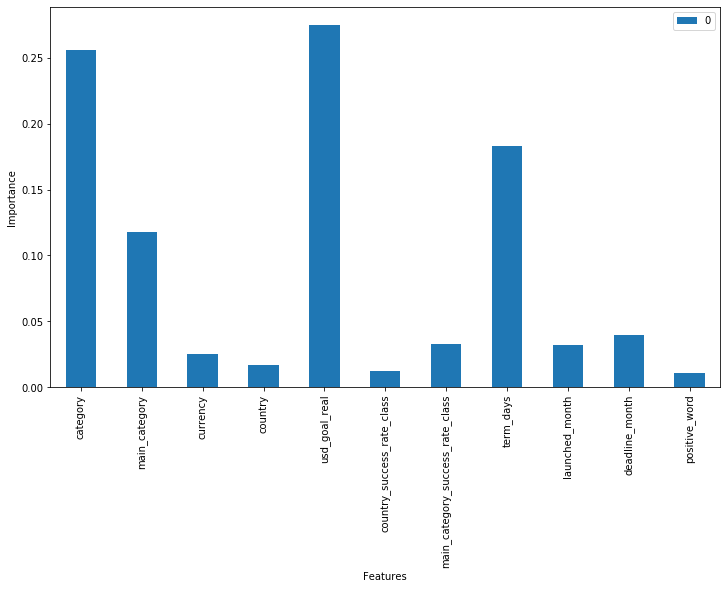

CPU times: user 29.9 s, sys: 624 ms, total: 30.5 s
Wall time: 7.46 s


In [12]:
%%time

# アダブースト
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5,
                                                    min_samples_leaf = 26,
                                                    min_samples_split = 2, 
                                                    random_state=1234,
                                                    criterion="gini"),
                                                       n_estimators=22, random_state=1234)
clf.fit(X_train, y_train)
print("score=", clf.score(X_train, y_train))

# 説明変数の重要度を出力する
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=df_X_train.columns).plot.bar(figsize=(12,7))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

### 5. 評価

In [13]:
# ラベルを予測
y_pred = clf.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
# Precision, Recall, F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

# 表示
print("Accuracy(正答率) = {:.3f}%".format(accuracy * 100))
print("Precision(適合率) = {:.3f}%".format(precision[1] * 100))
print("Recall(再現率) = {:.3f}%".format(recall[1] * 100))
print("F1-score(F1値) = {:.3f}%".format(f1_score[1] * 100))

Accuracy(正答率) = 69.122%
Precision(適合率) = 56.452%
Recall(再現率) = 57.111%
F1-score(F1値) = 56.780%


In [14]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                            index=["正解 = failed", "正解 = successful"], 
                        columns=["予測 = failed", "予測 = successful"])
conf_mat

,予測 = failed,予測 = successful
正解 = failed,36714,11762
正解 = successful,11450,15247


### 6. 特徴量選択
#### (ステップワイズ法による特徴選択)

In [15]:
from sklearn.feature_selection import RFECV

estimator = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5,
                                                    min_samples_leaf = 26,
                                                    min_samples_split = 2, 
                                                    random_state=1234,
                                                    criterion="gini"),
                                                       n_estimators=22, random_state=1234)
rfecv = RFECV(estimator, cv=3, scoring='accuracy')

# fitで特徴選択を実行
rfecv.fit(X_train, y_train)

RFECV(cv=3,
      estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                         criterion='gini',
                                                                         max_depth=5,
                                                                         max_features=None,
                                                                         max_leaf_nodes=None,
                                                                         min_impurity_decrease=0.0,
                                                                         min_impurity_split=None,
                                                                         min_samples_leaf=26,
                                                                         min_samples_split=2,
                                                                         min_weight_fractio

In [16]:
# 特徴のランキングを表示（1が最も重要な特徴）
print('Feature ranking: \n{}'.format(rfecv.ranking_))

Feature ranking: 
[1 1 1 1 1 1 1 1 1 1 1]


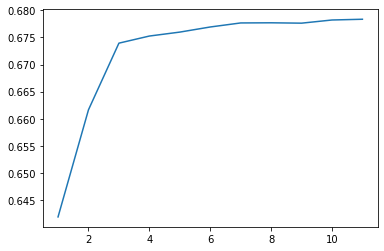

max=0.678366


In [17]:
# 特徴数とスコアの変化をプロット
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()
print("max=%05f"%np.max(rfecv.grid_scores_))

特徴量全部使うのが良い

### 7. ハイパーパラメータチューニング(グリッドサーチ)

In [18]:
%%time

# 木モデルを複数パターン用意
estimators = []
for depth in [3, 5, 7]:
    for leafs in [24, 26, 28]:
        for splits in [2, 3, 4]:
            estimators.append(DecisionTreeClassifier(max_depth = depth, min_samples_leaf = leafs, min_samples_split = splits))
param = {"base_estimator":estimators,
        "n_estimators":[20, 22, 24]}
model = AdaBoostClassifier(random_state=1234)
clf = GridSearchCV(model, param, cv=3,)
clf.fit(X_train, y_train)
print(clf.best_params_, clf.best_score_)

{'base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=24, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best'), 'n_estimators': 20} 0.6794405669832053
CPU times: user 1h 40min 44s, sys: 1min 57s, total: 1h 42min 41s
Wall time: 20min 21s


### 8. グリッドサーチした結果で再学習

In [19]:
%%time

# アダブースト
clf = AdaBoostClassifier(**clf.best_params_, random_state=1234)
clf.fit(X_train, y_train)
print("score=", clf.score(X_train, y_train))

score= 0.6857548615574062
CPU times: user 26.9 s, sys: 505 ms, total: 27.4 s
Wall time: 6.34 s


### 9. 最終結果

In [20]:
# ラベルを予測
y_pred = clf.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
# Precision, Recall, F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred)

# 表示
print("Accuracy(正答率) = {:.3f}%".format(accuracy * 100))
print("Precision(適合率) = {:.3f}%".format(precision[1] * 100))
print("Recall(再現率) = {:.3f}%".format(recall[1] * 100))
print("F1-score(F1値) = {:.3f}%".format(f1_score[1] * 100))

Accuracy(正答率) = 69.009%
Precision(適合率) = 56.311%
Recall(再現率) = 56.819%
F1-score(F1値) = 56.564%


In [21]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat = pd.DataFrame(conf_mat, 
                            index=["正解 = failed", "正解 = successful"], 
                        columns=["予測 = failed", "予測 = successful"])
conf_mat

,予測 = failed,予測 = successful
正解 = failed,36707,11769
正解 = successful,11528,15169
